In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


100%|██████████| 170498071/170498071 [00:03<00:00, 43355483.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 3, 32, 32])
torch.Size([64])


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
d_noise = 100
d_hidden_1 = 256
d_hidden_2 = 256
image_dim = 32*32
batch_size = 64

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(d_noise, 256, kernel_size=8, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), d_noise, 1, 1)  # 입력 잡음 벡터를 (batch_size, d_noise, 1, 1) 형태로 변환
        x = self.generator(x)
        return x

    def forward(self, x):
        x = self.generator(x)
        return x

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(3*32*32, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 10),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.discriminator(x)
        return x

In [6]:
disc = Discriminator().to(device)
gen = Generator().to(device)

fixed_noise = torch.randn(batch_size, d_noise).view(batch_size, d_noise, 1, 1).to(device)

lr = 3e-4
num_epochs = 50

opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

step = 0

In [40]:
fake_list = []
real_list = []

num_epochs = 10

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(train_loader):
        real = real.view(-1, 3*32*32).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, d_noise).view(batch_size, d_noise, 1, 1).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.view(-1, 3*32*32)).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake.view(-1, 3*32*32)).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 3, 32, 32)
                data = real.reshape(-1, 3, 32, 32)

                fake_list.append(fake)
                real_list.append(data)
                step += 1

Epoch [0/10] Loss D: 0.4434, loss G: 1.3528
Epoch [1/10] Loss D: 0.4941, loss G: 1.4464
Epoch [2/10] Loss D: 0.4997, loss G: 1.3864
Epoch [3/10] Loss D: 0.4251, loss G: 1.5733
Epoch [4/10] Loss D: 0.4547, loss G: 1.4410
Epoch [5/10] Loss D: 0.3941, loss G: 1.4216
Epoch [6/10] Loss D: 0.4649, loss G: 1.3534
Epoch [7/10] Loss D: 0.4495, loss G: 1.7913
Epoch [8/10] Loss D: 0.5228, loss G: 1.2846
Epoch [9/10] Loss D: 0.5077, loss G: 1.4224


TypeError: Invalid shape (3, 32, 32) for image data

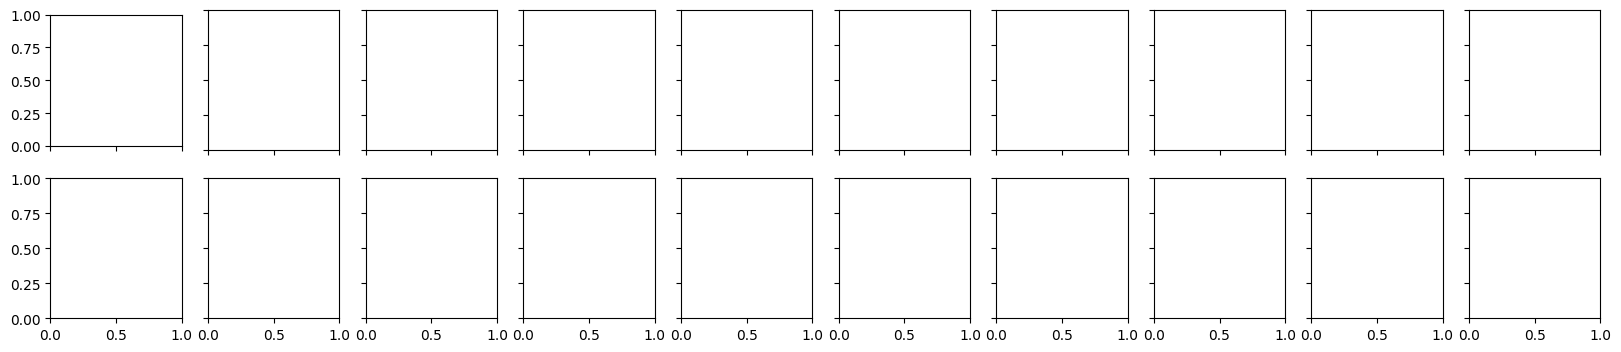

In [41]:
# 원본 이미지와 복원된 이미지 시각화
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20, 4))

for images, row in zip([fake_list[0], fake_list[-1]], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.cpu().numpy().squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()

<class 'torch.Tensor'>
torch.Size([64, 3, 32, 32])


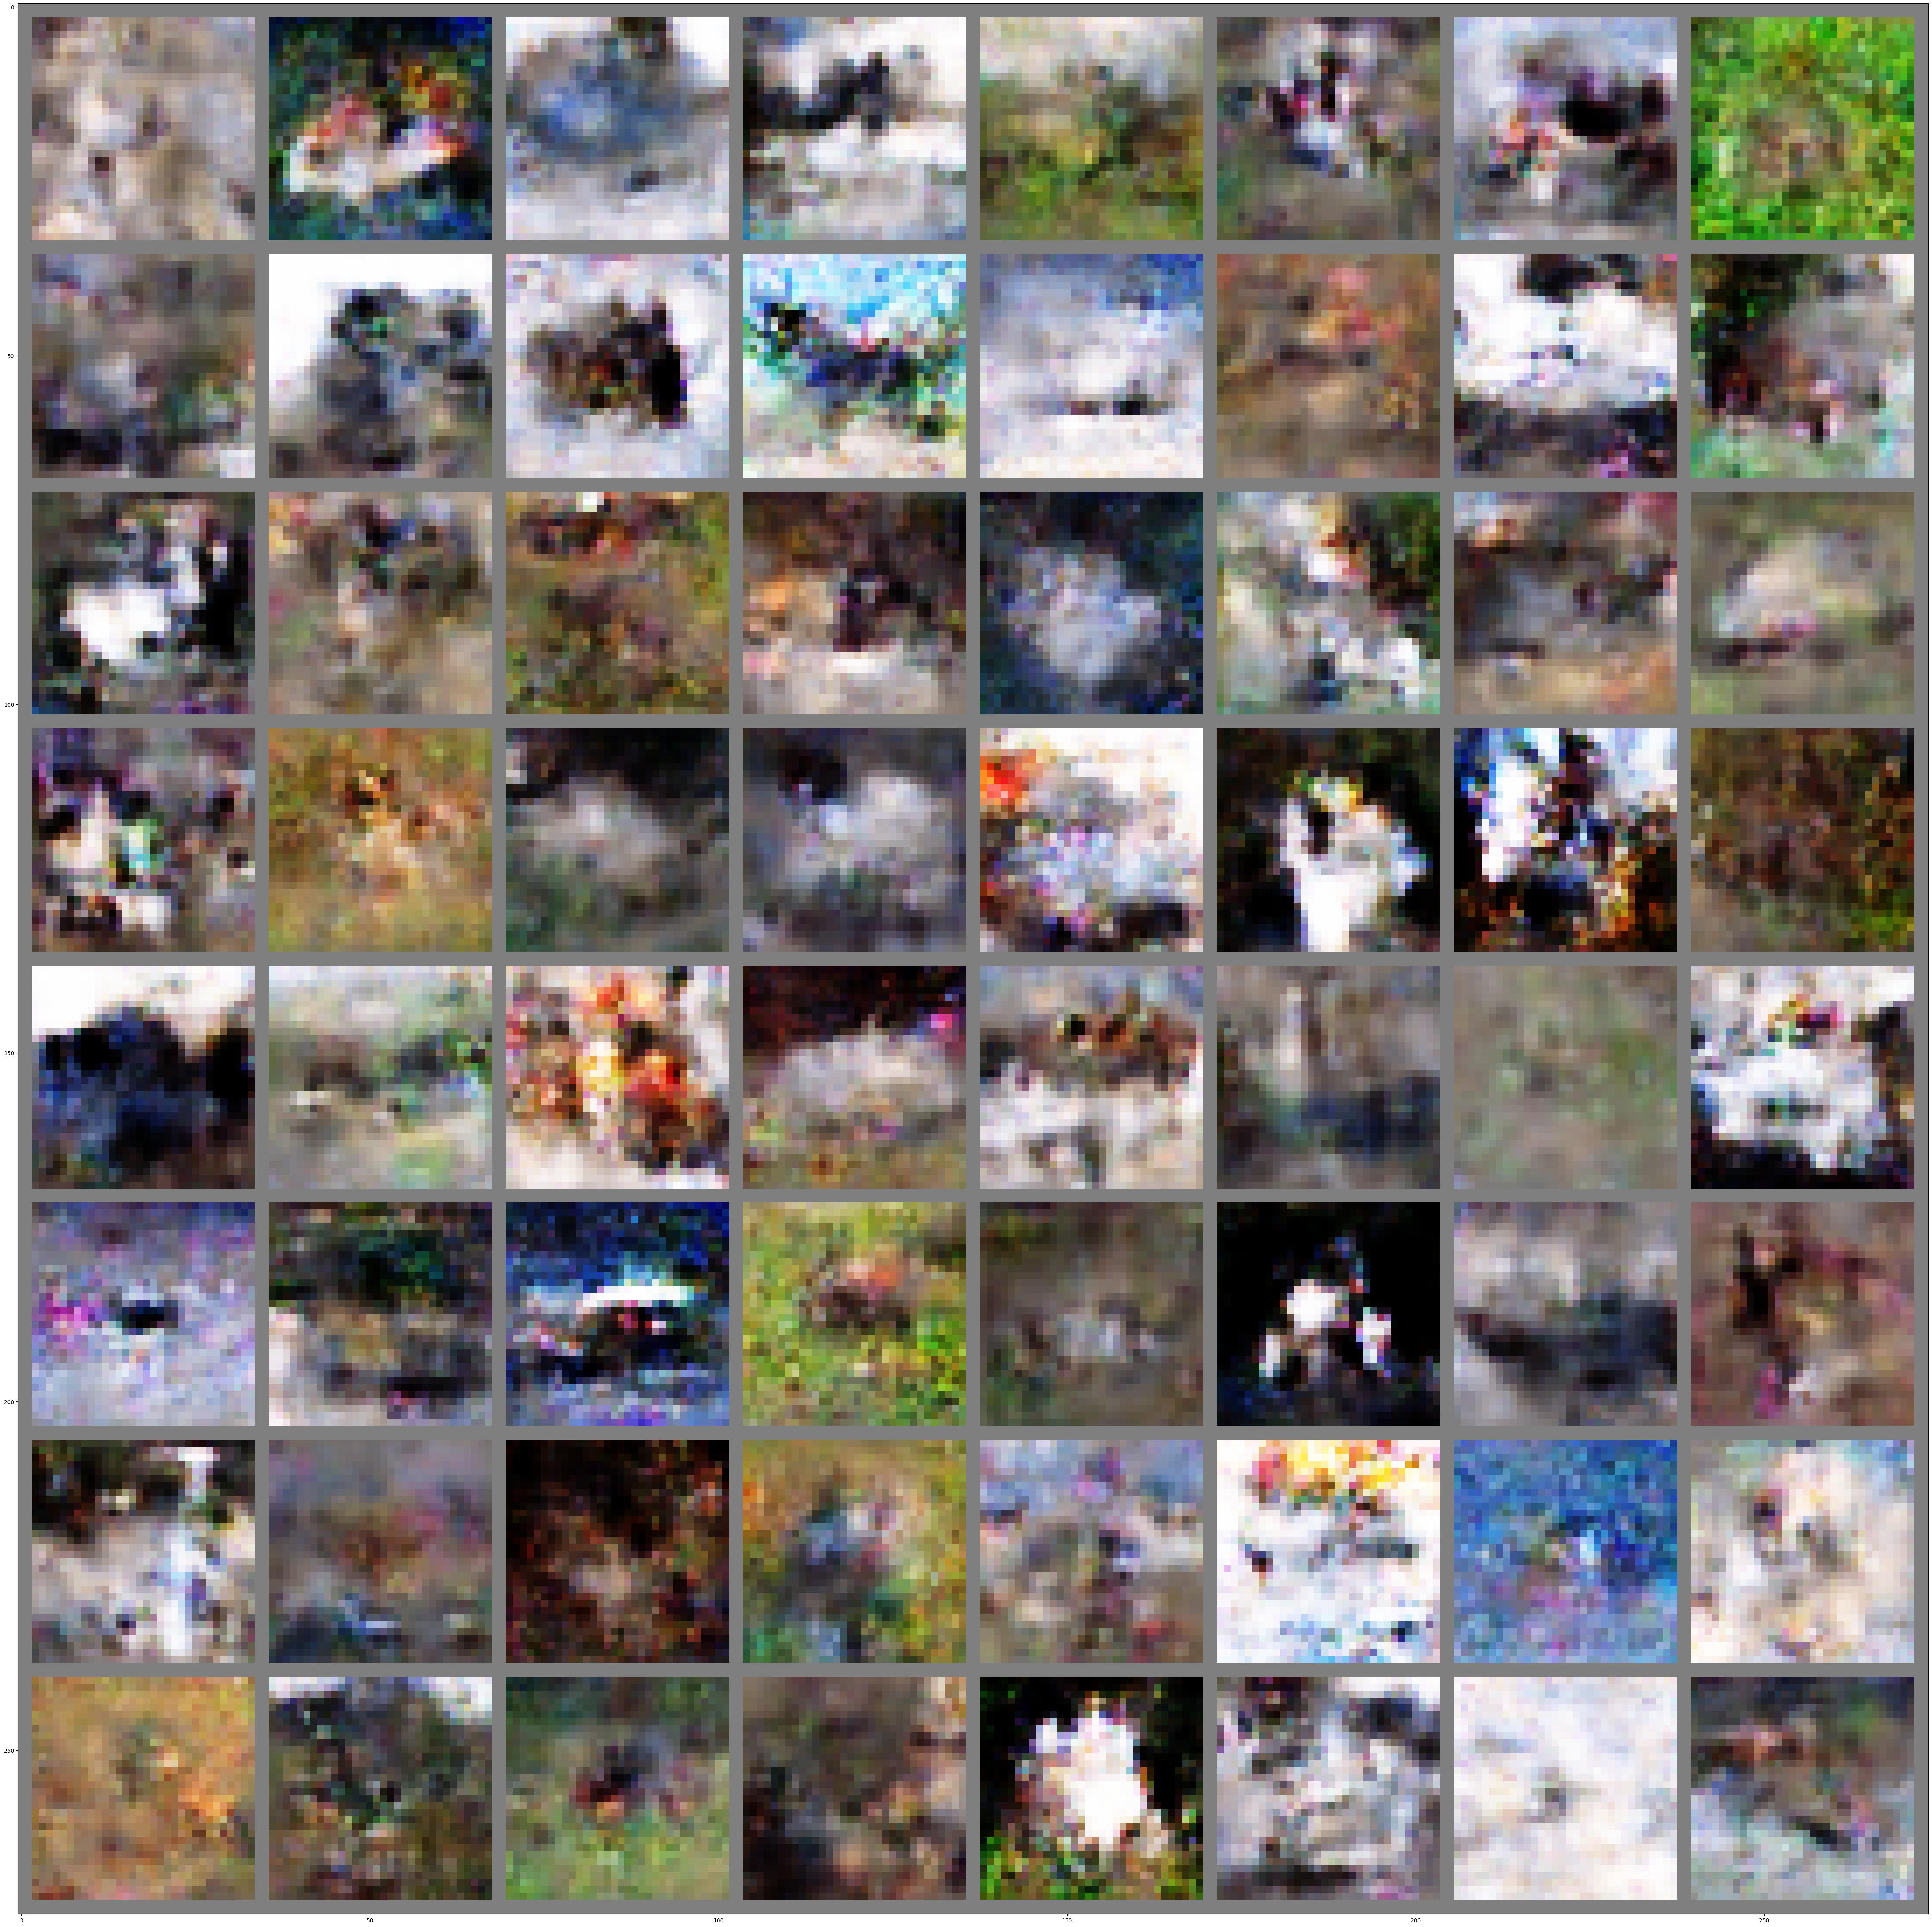

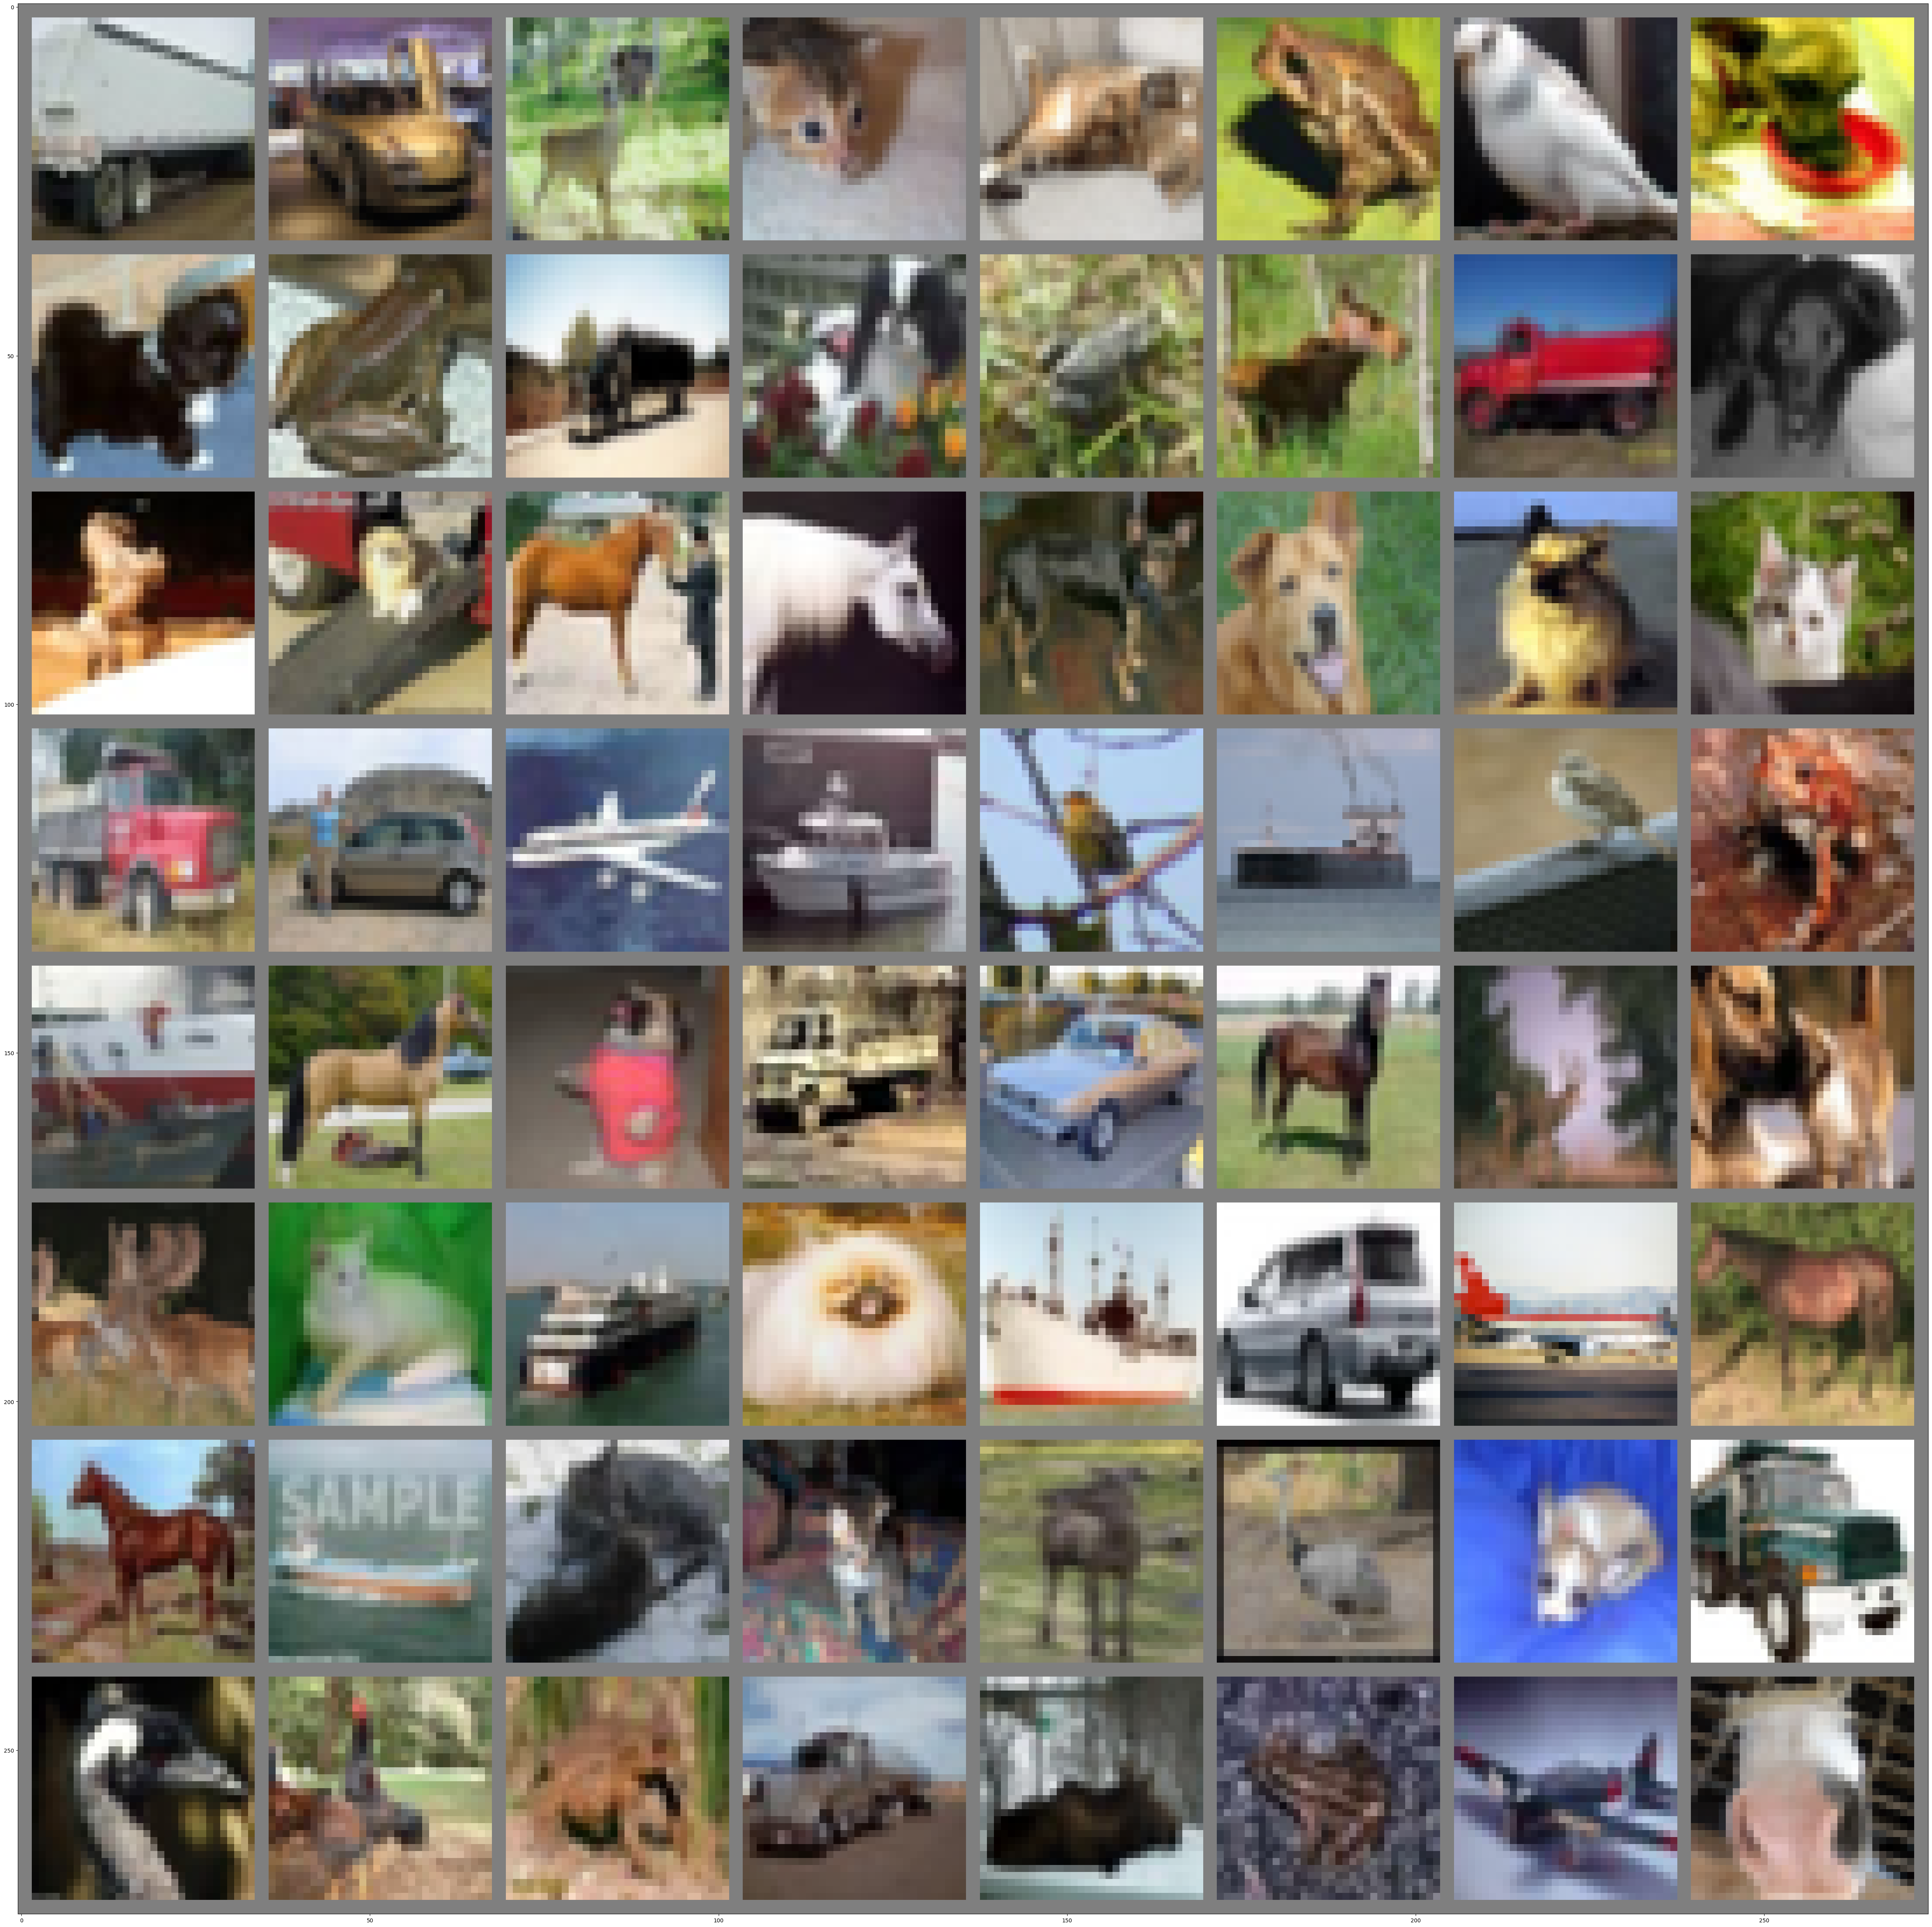

In [46]:
import torch
import numpy as np
import torchvision.transforms as transforms
from PIL import Image

# 정규화 파라미터
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

# 정규화 해제 변환 정의
def denormalize(tensor, mean, std):
    """
    텐서를 원래 이미지로 되돌리기 위해 정규화 해제하는 함수
    """

    # 텐서를 NumPy 배열로 변환
    tensor = tensor.clone().cpu()
    tensor = tensor * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)

    # 텐서를 [0, 1] 범위로 클리핑
    tensor = torch.clamp(tensor, 0, 1)

    # 텐서를 NumPy 배열로 변환
    np_image = tensor.numpy().transpose(1, 2, 0)

    # NumPy 배열을 PIL 이미지로 변환
    return np_image

import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    plt.figure(figsize=(64, 64))
    npimg = denormalize(img, mean, std)  # unnormalize
    #npimg = img.cpu().numpy()
    plt.imshow(npimg)
    plt.show()
    # 학습용 이미지를 무작위로 가져오기
#dataiter = iter(trainloader)
images = fake_list[-1]
print(type(images))
print(images.shape)
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력

images = real_list[-1]

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력


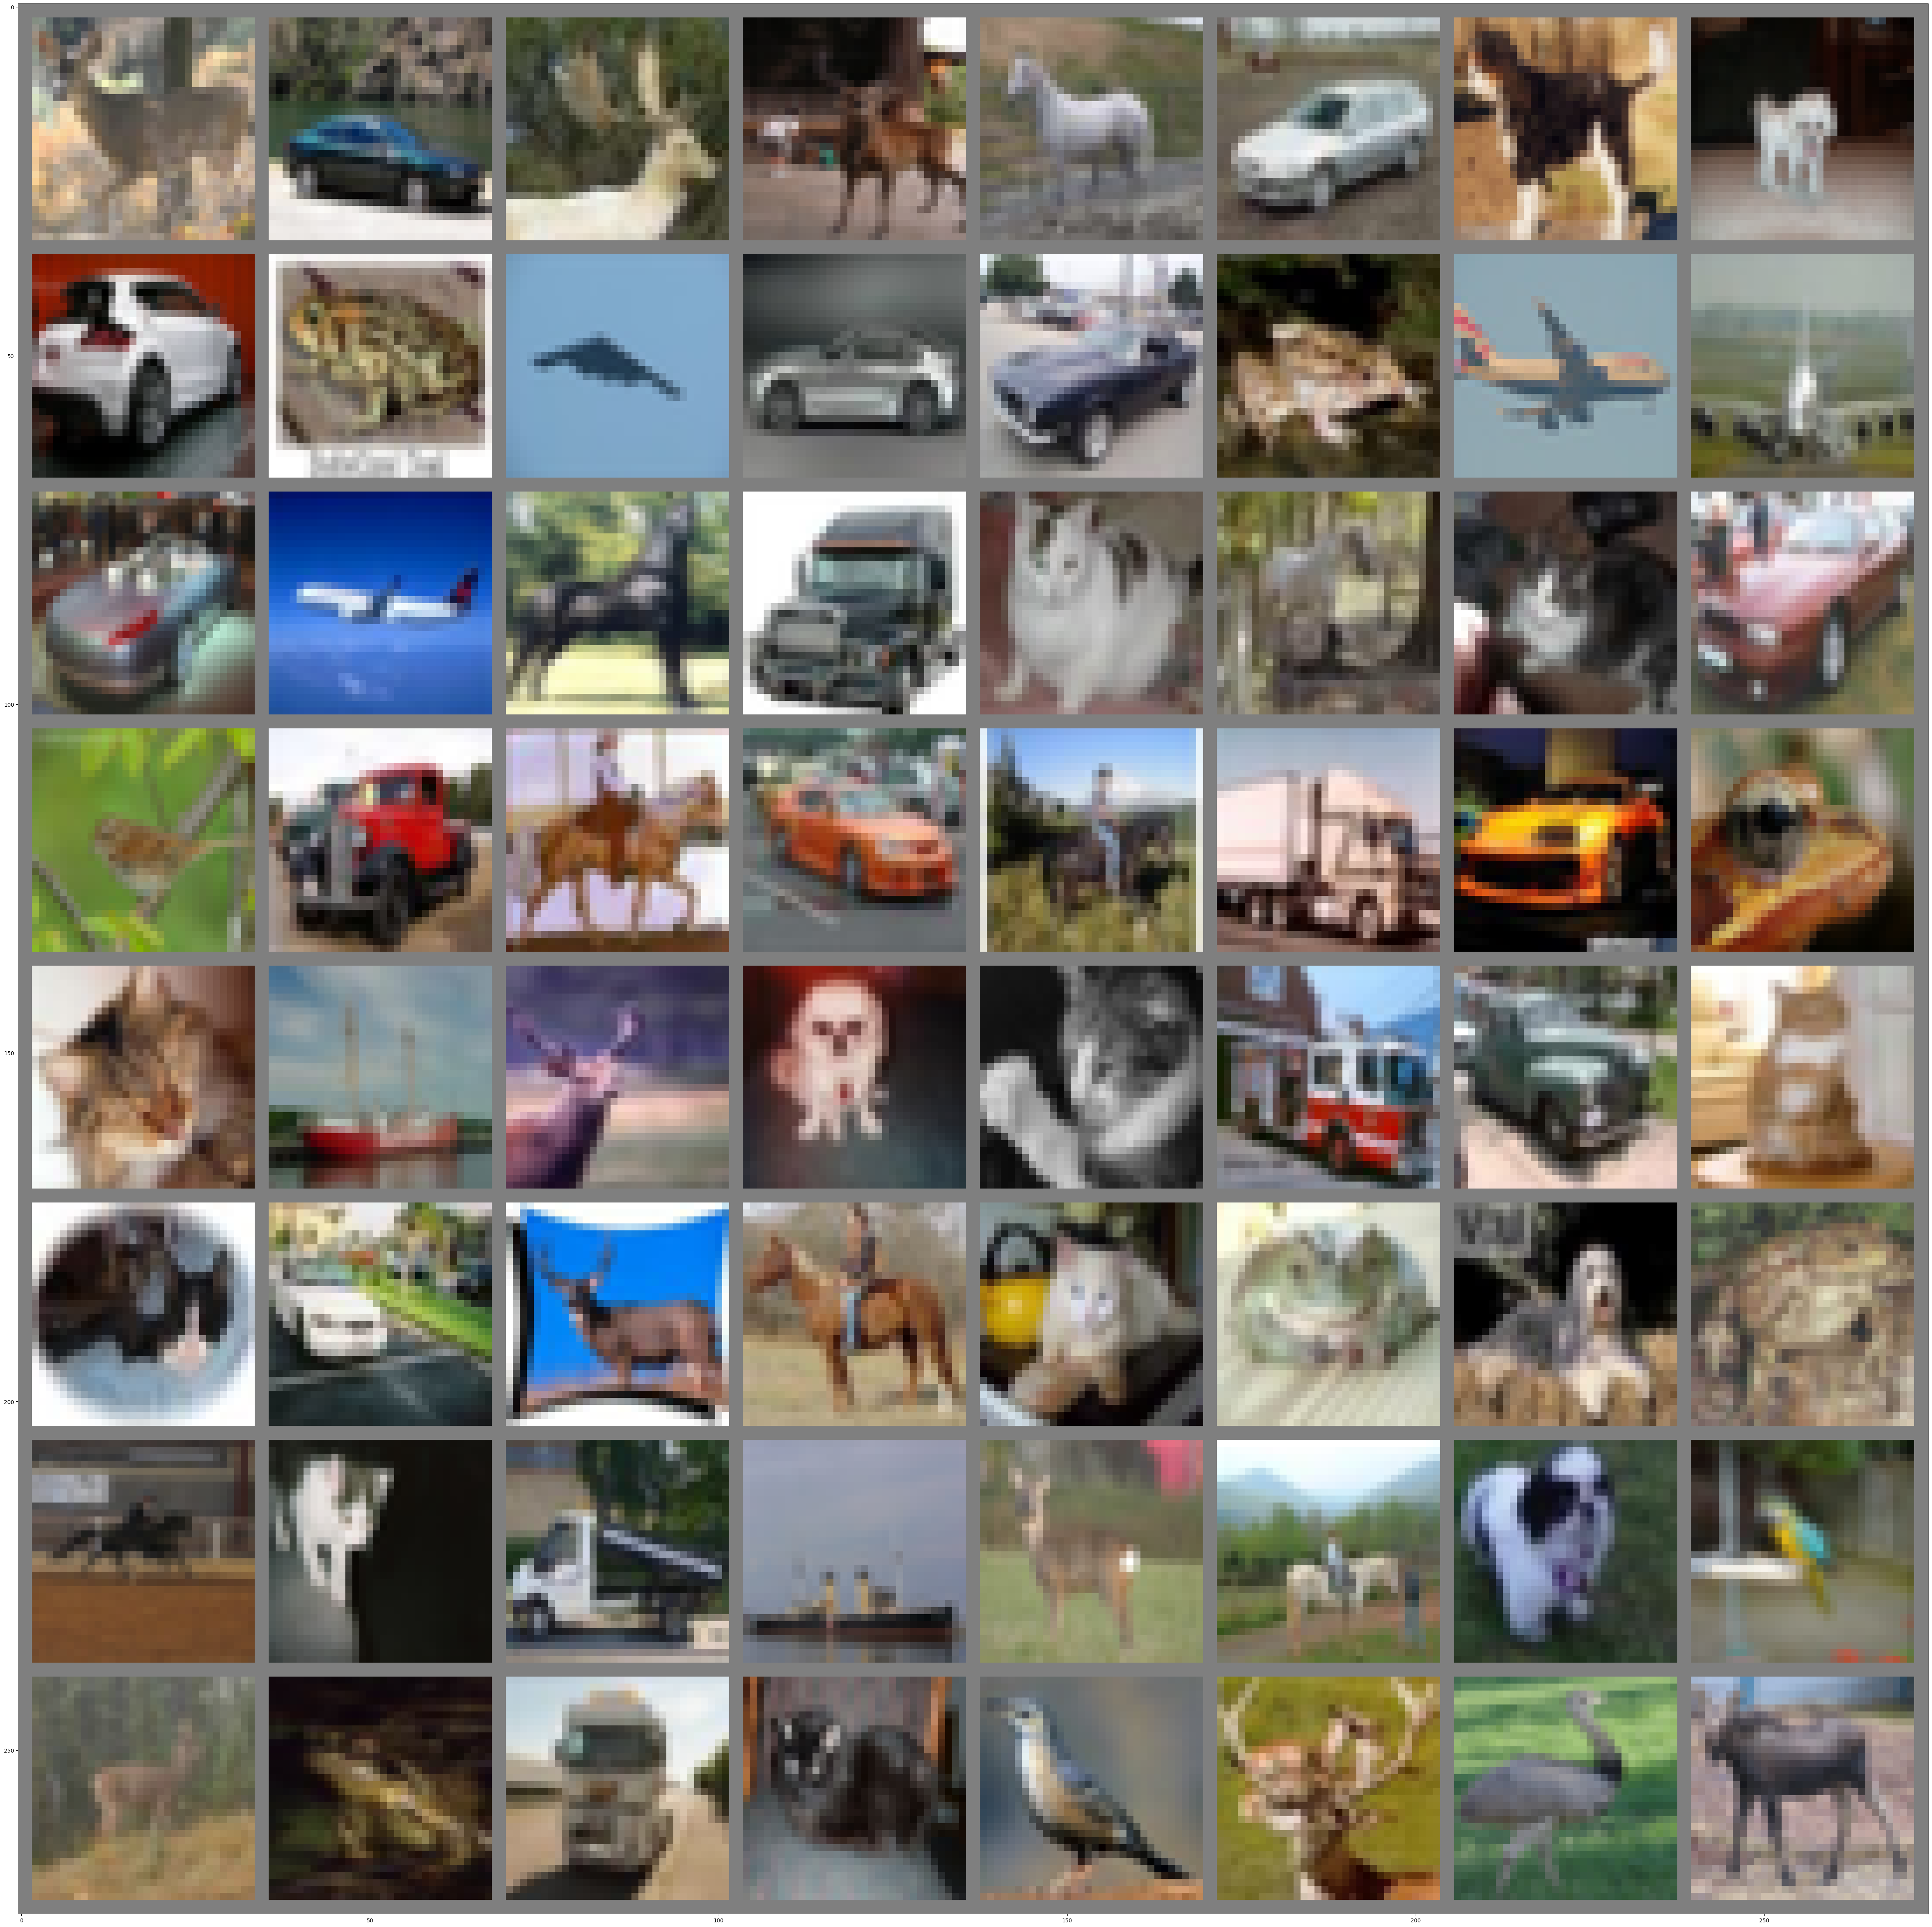

In [44]:
images = real_list[-2]

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

Type of images: <class 'torch.Tensor'>
Shape of images: torch.Size([192, 1, 32, 32])


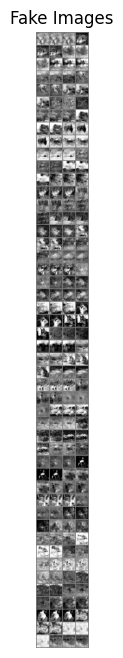

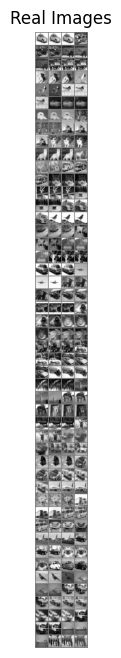

In [32]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision.utils as vutils
from PIL import Image
import matplotlib.pyplot as plt

# 정규화 파라미터
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

# 정규화 해제 변환 정의
def denormalize(tensor, mean, std):
    """
    텐서를 원래 이미지로 되돌리기 위해 정규화 해제하는 함수
    """
    # 텐서를 GPU에서 CPU로 이동
    tensor = tensor.clone().cpu()

    # 평균과 표준편차를 이용해 정규화 해제
    tensor = tensor * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)

    # [0, 1] 범위로 클리핑
    tensor = torch.clamp(tensor, 0, 1)

    # 텐서를 NumPy 배열로 변환
    np_image = tensor.numpy().transpose(1, 2, 0)

    return np_image

# 이미지를 보여주기 위한 함수
def imshow(img, title=None):
    plt.figure(figsize=(8, 8))  # 이미지 크기를 조정
    plt.imshow(denormalize(img, mean, std))
    if title is not None:
        plt.title(title)
    plt.axis('off')  # 축을 숨김
    plt.show()

# 예제 데이터
import torchvision


# 학습용 이미지를 무작위로 가져오기
images = fake_list[-1]
print("Type of images:", type(images))
print("Shape of images:", images.shape)

# 이미지 보여주기
imshow(vutils.make_grid(images, nrow=4), title='Fake Images')

# 실제 이미지
images = real_list[0]

# 이미지 보여주기
imshow(vutils.make_grid(images, nrow=4), title='Real Images')


In [9]:
!pip install tensorboard

In [10]:
!tensorboard --logdir=runs

2024-07-31 00:24:22.205527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 00:24:22.205585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 00:24:22.207268: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 00:24:23.747433: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to 

In [11]:
%load_ext tensorboard
%tensorboard --logdir=runs


Launching TensorBoard...

KeyboardInterrupt: 

In [ ]:
# 모델 초기화
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print(model)

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    for data, _ in train_loader:
        data = data.view(-1, 28 * 28).to(device)

        # 순전파
        output = model(data)
        loss = criterion(output, data)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# 테스트 데이터셋에서 몇 가지 이미지를 복원하여 시각화
model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.view(-1, 28 * 28).to(device)
        output = model(data)
        output = output.view(-1, 1, 28, 28).cpu()
        break

# 원본 이미지와 복원된 이미지 시각화
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20, 4))

for images, row in zip([data.view(-1, 1, 28, 28).cpu(), output], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.numpy().squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()